In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib
import sys
import os
# I had an issue with importing functions from the src directory, so I used chatGPT to get the line below
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import functions

In [2]:
input_path = Path.cwd()
root = input_path.parent
data_path = root / "data" / "development_final_data.csv"
train_df = pd.read_csv(data_path, header=0)
x = train_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
y = train_df['BMI']
val_df = pd.read_csv(root / "data" / "evaluation_final_data.csv", header=0)
val_x = val_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
val_y = val_df['BMI']

Model: ElasticNet


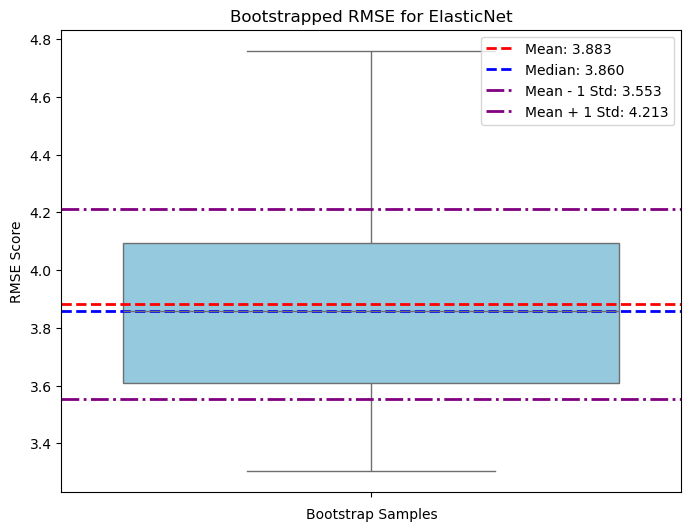

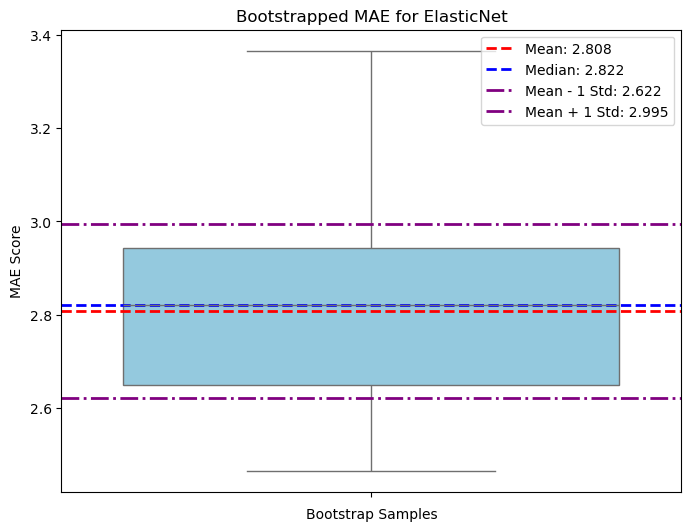

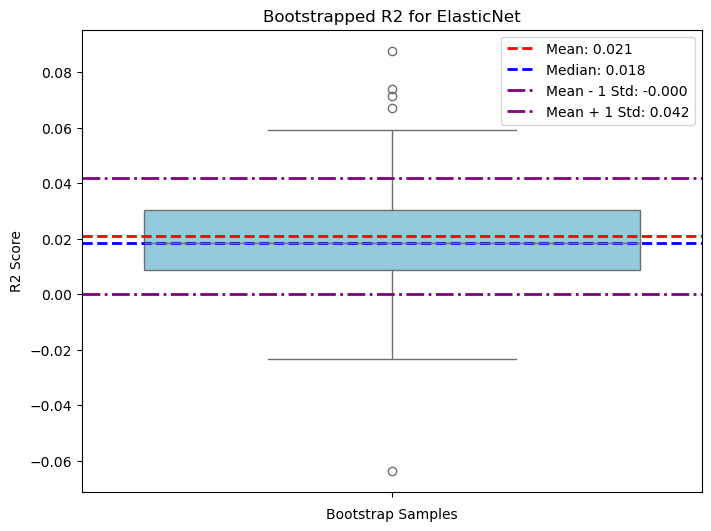

Model: BayesianRidge


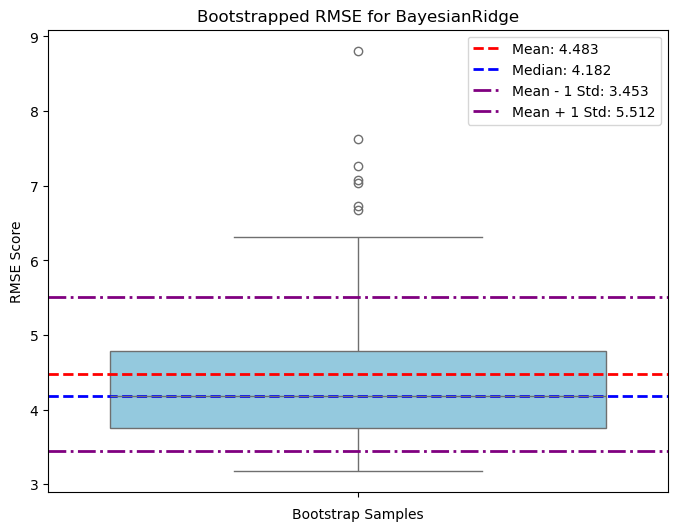

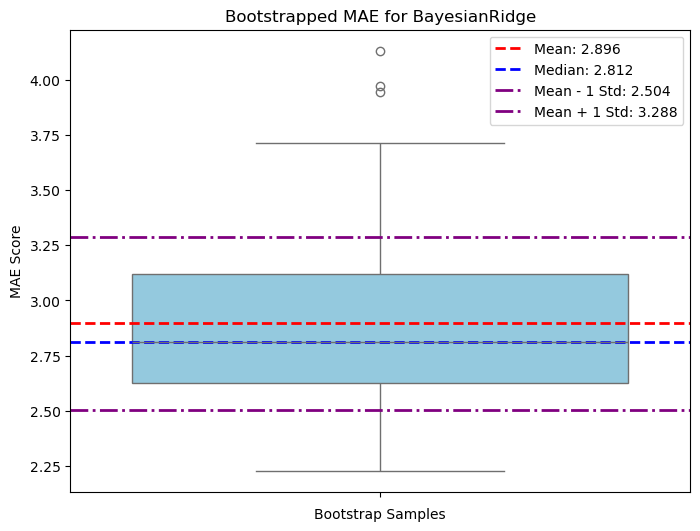

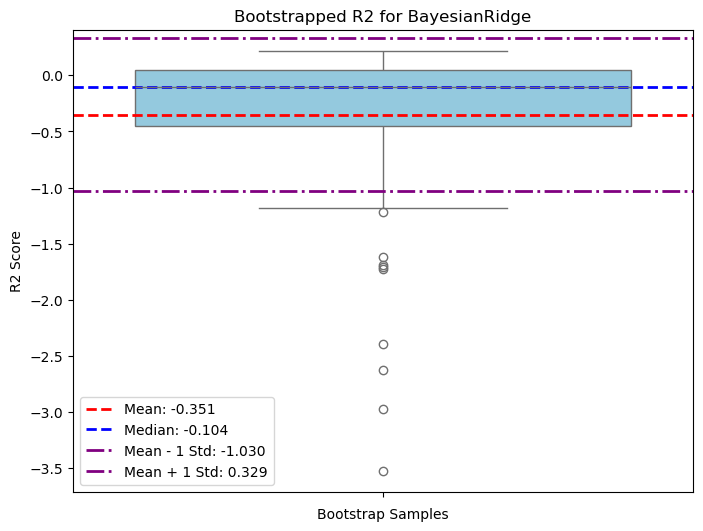

Model: SVR


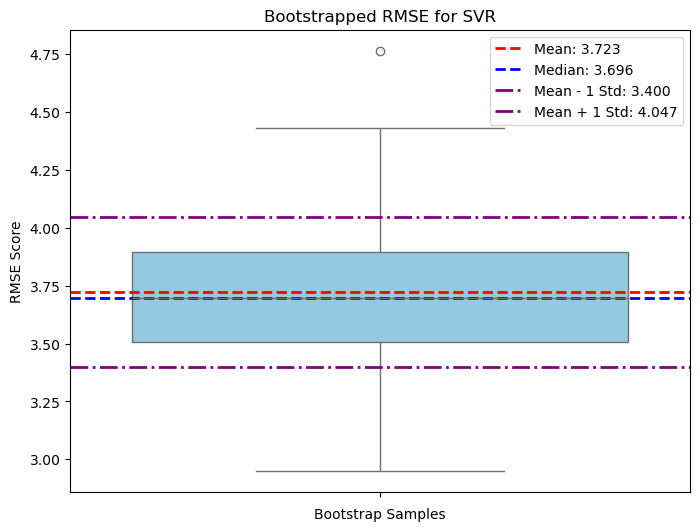

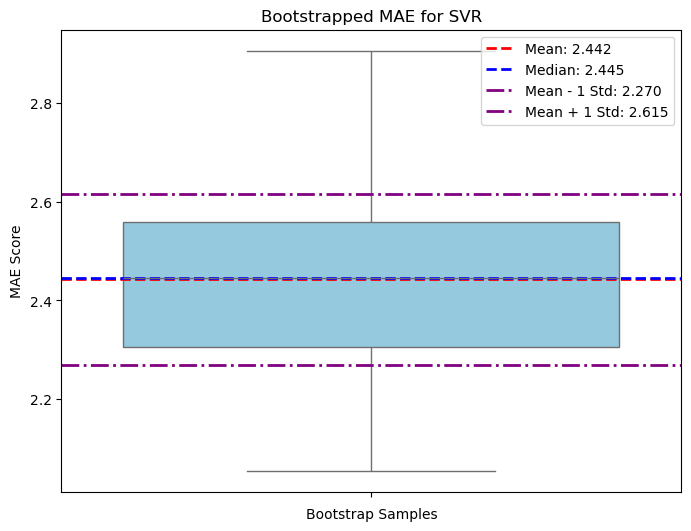

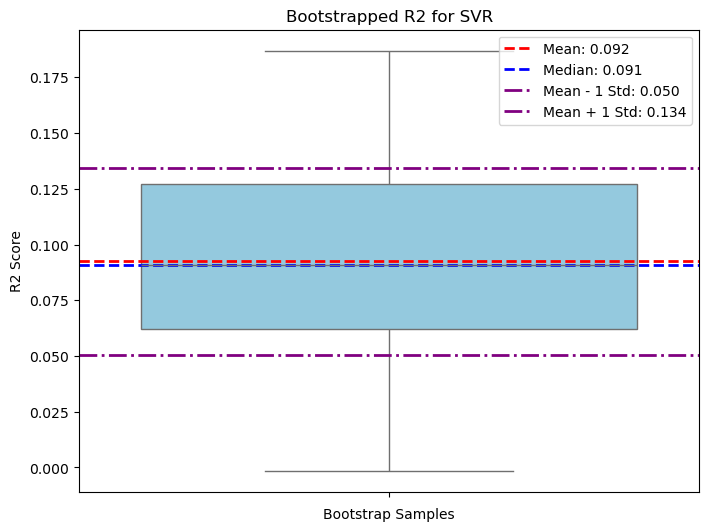

In [3]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, filename=model.__class__.__name__)
    # Calculate metrics
    rmse_scores, mae_scores, r2_scores = functions.bootstrap(x, y, val_x, val_y, trained_pipeline)
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot(rmse_scores, model.__class__.__name__, "RMSE", mean_rmse, std_rmse, median_rmse)
    functions.create_boxplot(mae_scores, model.__class__.__name__, "MAE", mean_mae, std_mae, median_mae)
    functions.create_boxplot(r2_scores, model.__class__.__name__, "R2", mean_r2, std_r2, median_r2)